In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# 환경 로딩

In [2]:
env = gym.make('FrozenLake-v0')

[2017-09-04 02:52:31,904] Making new env: FrozenLake-v0


# 네트워크 구현

In [3]:
tf.reset_default_graph()

In [4]:
#액션을 선택하는데 사용되는 네트워크의 피드-포워드 부분을 구축한다.
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#타겟 Q값과 예측 Q값을 제곱합한 차를 구함으로써 비용을 얻게 된다.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

# 네트워크 학습시키기

In [5]:
init = tf.global_variables_initializer()

# 학습 관련 파라미터를 설정한다.
y = .99
e = 0.1
num_episodes = 2000
#전체 보상과 에피소드별 스텝을 포함하기 위한 리스트를 생성한다.
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #환경을 리셋하고 첫번째 새로운 관찰을 얻는다.
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #Q-네트워크
        while j < 99:
            j+=1
            #Q-네트워크로부터 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택한다.
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #환경으로부터 새로운 상태와 보상을 얻는다.
            s1,r,d,_ = env.step(a[0])
            #새로운 상태를 네트워크에 피드해줌으로써 Q’값을 구한다.
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #maxQ'값을 구하고 선택된 액션에 대한 타겟 값을 설정한다.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #타겟과 예측된 Q값을 이용하여 네트워크를 학습시킨다.
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #모델을 학습해 나감에 따라 랜덤 액션의 가능성을 줄여간다.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.463%


# 네트워크 성능 관련 통계

약 750번째 에피소드 정도에 다다르면 네트워크가 지속적으로 목표에 도달하기 시작하는 것을 확인할 수 있습니다. 

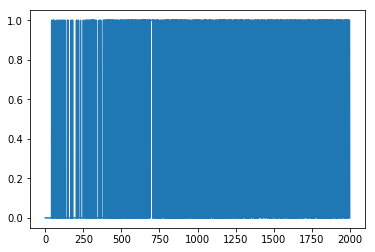

In [6]:
plt.plot(rList)

또한 750 에피소드 정도에서 환경을 통해 더 길게 진행하기 시작하는 것을 확인할 수 있습니다. 

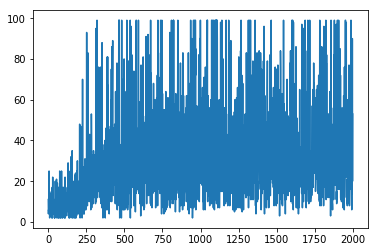

In [7]:
plt.plot(jList)